In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
url = "/content/아파트(전세)_서울마포구_20250928.csv"
try:
    df = pd.read_csv(url, encoding="utf-8", engine="python", sep=",")
except:
    try:
        df = pd.read_csv(url, encoding="cp949", engine="python", sep=",")
    except:
        print("Could not read the CSV file with utf-8 or cp949 encoding.")
        df = None


if df is not None:
    # 전세만 남기기
    df = df[df["월세금(만원)"] == 0].copy()
    df["보증금(만원)"] = df["보증금(만원)"].astype(str).str.replace(",", "").astype(int)


else:
    print("DataFrame is empty due to reading error.")

In [3]:
df.head()

,NO,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,...,월세금(만원),층,건축년도,도로명,계약기간,계약구분,갱신요구권 사용,종전계약 보증금(만원),종전계약 월세(만원),주택유형
0,1,서울특별시 마포구 상수동,402,402,0,래미안밤섬리베뉴Ⅰ,전세,125.31,202509,26,...,0,7,2014,독막로20나길 22,202510~202710,갱신,사용,"125,000",0.0,아파트
1,2,서울특별시 마포구 성산동,446,446,0,성산시영(대우),전세,50.03,202509,26,...,0,8,1986,월드컵북로 235,202510~202710,갱신,사용,"27,000",0.0,아파트
4,5,서울특별시 마포구 망원동,513,513,0,상암마젤란21,전세,55.85,202509,26,...,0,4,2005,방울내로11길 43,202509~202709,갱신,사용,"40,000",0.0,아파트
5,6,서울특별시 마포구 망원동,513,513,0,상암마젤란21,전세,55.85,202509,26,...,0,4,2005,방울내로11길 43,202509~202709,갱신,사용,"40,000",0.0,아파트
6,7,서울특별시 마포구 상암동,1660,1660,0,상암월드컵파크7단지,전세,84.74,202509,26,...,0,12,2005,상암산로1길 92,202511~202711,신규,-,NaN,NaN,아파트


In [4]:
# ✅ '갱신요구권 사용' 컬럼이 존재하는지 확인
if "갱신요구권 사용" in df.columns:
    before = len(df)
    # '사용' 값 제거 (즉, 사용 안한 행만 남김)
    df = df[df["갱신요구권 사용"].astype(str).str.strip() != "사용"]
    after = len(df)
    print(f"✅ 갱신청구권 사용 항목 삭제 완료: {before - after}건 제거, {after}건 남음")
else:
    print("⚠️ '갱신요구권 사용' 컬럼이 데이터에 없습니다.")

✅ 갱신청구권 사용 항목 삭제 완료: 1557건 제거, 5139건 남음


In [5]:
# 필요한 컬럼만 남기기
cols = ["시군구", "단지명", "전용면적(㎡)", "계약년월", "계약일", "보증금(만원)", "층", "건축년도", "계약구분"]
df = df[cols].dropna()

In [6]:
# 결과 저장 (선택)
df.to_csv("아파트(전세)_서울마포구_갱신미사용만.csv", index=False, encoding="utf-8-sig")

<Figure size 1200x600 with 0 Axes>

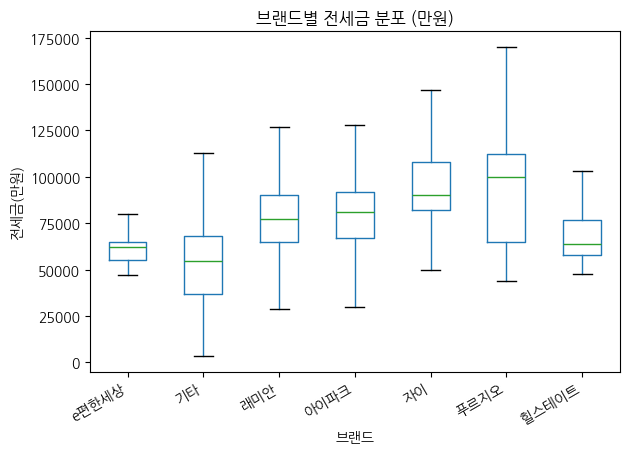

[저장] 브랜드별_전세금_분포_boxplot.png


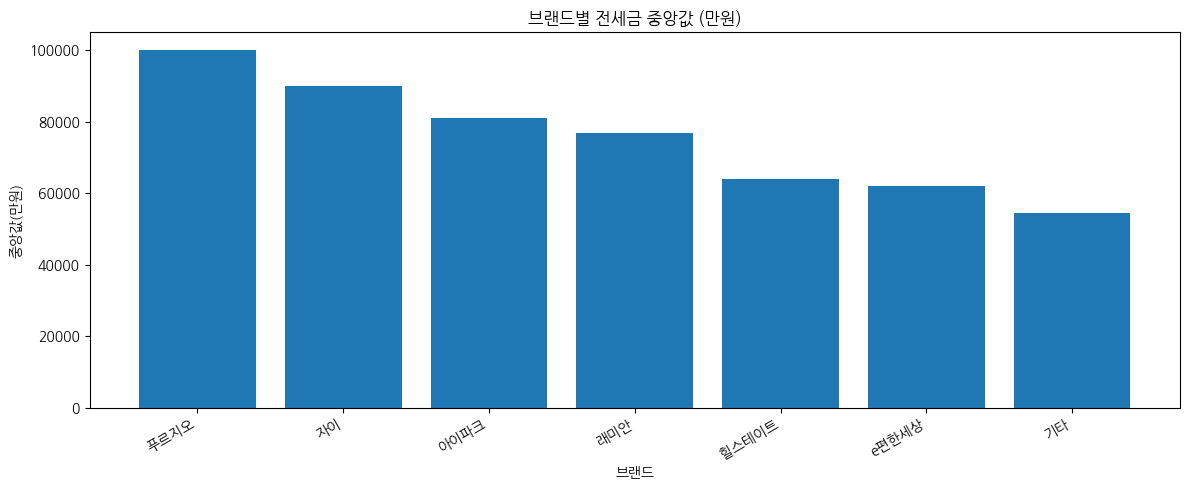

[저장] 브랜드별_전세금_중앙값_bar.png


<Figure size 1200x600 with 0 Axes>

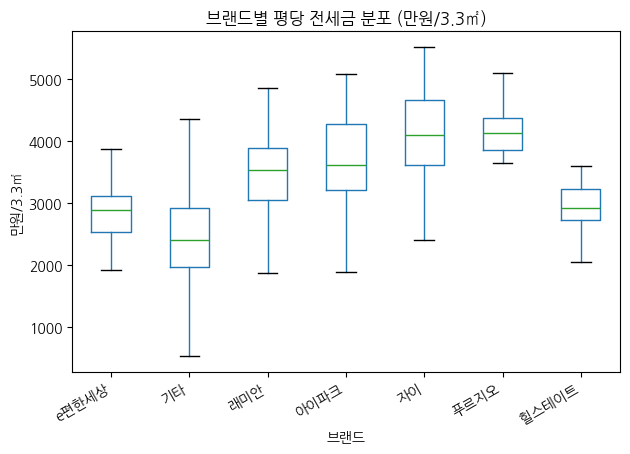

[저장] 브랜드별_평당전세금_분포_boxplot.png


In [ ]:
# -*- coding: utf-8 -*-
import os
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# =========================
# 0) 환경: 한글 폰트 설정
# =========================
mpl.rcParams['axes.unicode_minus'] = False
sysname = platform.system()
if sysname == "Windows":
    mpl.rcParams['font.family'] = "Malgun Gothic"
elif sysname == "Darwin":
    mpl.rcParams['font.family'] = "AppleGothic"
else:
    # Linux/Colab: 나눔고딕 설치 시도
    try:
        nanum = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
        if not os.path.exists(nanum):
            import subprocess
            subprocess.run(["apt-get", "-qq", "update"], check=True)
            subprocess.run(["apt-get", "-qq", "-y", "install", "fonts-nanum"], check=True)
        if os.path.exists(nanum):
            fm.fontManager.addfont(nanum)
            mpl.rcParams['font.family'] = "NanumGothic"
    except Exception:
        pass

# =========================
# 1) 데이터 로드 & 정리
# =========================
CSV_PATH = "아파트(전세)_서울마포구_갱신미사용만.csv"  # 파일 경로를 환경에 맞게 수정

# 인코딩 시도
try:
    df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(CSV_PATH, encoding="cp949")

# 필수 컬럼 점검
need_cols = ["단지명", "보증금(만원)"]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"필수 컬럼 누락: {missing}")

# 보증금 숫자화 (문자열에 쉼표가 있을 수 있음)
if df["보증금(만원)"].dtype == object:
    df["보증금(만원)"] = (
        df["보증금(만원)"].astype(str).str.replace(",", "", regex=False)
        .replace({"": np.nan, "-": np.nan})
        .astype(float)
    )

# =========================
# 2) 단지명 → 브랜드 추출
# =========================
# 자주 쓰이는 브랜드 키워드 패턴 (필요시 추가/수정)
brand_patterns = [
    (r"래미안", "래미안"),
    (r"자이", "자이"),
    (r"푸르지오", "푸르지오"),
    (r"롯데\s*캐슬|롯데캐슬", "롯데캐슬"),
    (r"힐스테이트", "힐스테이트"),
    (r"e\s*편한세상|e편한세상|e-편한세상", "e편한세상"),
    (r"아이파크|IPARK", "아이파크"),
    (r"더샵", "더샵"),
    (r"센트레빌", "센트레빌"),
    (r"위브", "위브"),
    (r"스위첸", "스위첸"),
    (r"호반\s*베르디움|베르디움", "호반베르디움"),
    (r"우남", "우남"),
    (r"두산위브", "두산위브"),
    (r"트리마제", "트리마제"),
    (r"리버뷰|리버스", "리버뷰"),
    (r"리센츠", "리센츠"),
    (r"수자인", "수자인"),
    (r"에코델타|에코", "에코"),
    # 필요 시 계속 추가
]

def extract_brand(name: str) -> str:
    if not isinstance(name, str):
        return "기타"
    for pat, label in brand_patterns:
        if re.search(pat, name, flags=re.IGNORECASE):
            return label
    return "기타"

df["브랜드"] = df["단지명"].apply(extract_brand)

# =========================
# 3) 분석용 필터 (옵션)
# =========================
# 표본이 너무 적은 브랜드는 제외 (예: 10건 미만 제거)
min_samples = 10
brand_counts = df.groupby("브랜드")["보증금(만원)"].count()
valid_brands = brand_counts[brand_counts >= min_samples].index.tolist()
df_plot = df[df["브랜드"].isin(valid_brands)].dropna(subset=["보증금(만원)"])

if df_plot.empty:
    raise ValueError("유효 브랜드 표본이 없습니다. min_samples를 낮추거나 brand_patterns를 점검하세요.")

# =========================
# 4) Boxplot: 브랜드별 전세금 분포
# =========================
plt.figure(figsize=(12, 6))
# 브랜드 정렬: 중앙값 높은 순
order = (
    df_plot.groupby("브랜드")["보증금(만원)"]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)
# 박스플롯
df_plot.boxplot(column="보증금(만원)", by="브랜드", grid=False, showfliers=False)
plt.suptitle("")  # 자동 제목 제거
plt.title("브랜드별 전세금 분포 (만원)")
plt.xlabel("브랜드")
plt.ylabel("전세금(만원)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
BOX_PNG = "브랜드별_전세금_분포_boxplot.png"
plt.savefig(BOX_PNG, dpi=150)
plt.show()
print(f"[저장] {BOX_PNG}")

# =========================
# 5) Bar: 브랜드별 전세금 중앙값 (옵션)
# =========================
median_by_brand = (
    df_plot.groupby("브랜드")["보증금(만원)"]
    .median()
    .sort_values(ascending=False)
)
plt.figure(figsize=(12, 5))
plt.bar(median_by_brand.index, median_by_brand.values)
plt.title("브랜드별 전세금 중앙값 (만원)")
plt.xlabel("브랜드")
plt.ylabel("중앙값(만원)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
BAR_PNG = "브랜드별_전세금_중앙값_bar.png"
plt.savefig(BAR_PNG, dpi=150)
plt.show()
print(f"[저장] {BAR_PNG}")

# =========================
# 6) (선택) 면적 보정 비교: 3.3㎡당 전세금
# =========================
if "전용면적(㎡)" in df_plot.columns:
    df_area = df_plot.copy()
    df_area = df_area[df_area["전용면적(㎡)"] > 0]
    # 3.3㎡(1평)당 전세금(만원)
    df_area["평당전세금(만원)"] = df_area["보증금(만원)"] / (df_area["전용면적(㎡)"] / 3.3)

    # 박스플롯 (평당)
    plt.figure(figsize=(12, 6))
    df_area.boxplot(column="평당전세금(만원)", by="브랜드", grid=False, showfliers=False)
    plt.suptitle("")
    plt.title("브랜드별 평당 전세금 분포 (만원/3.3㎡)")
    plt.xlabel("브랜드")
    plt.ylabel("만원/3.3㎡")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    PER_PNG = "브랜드별_평당전세금_분포_boxplot.png"
    plt.savefig(PER_PNG, dpi=150)
    plt.show()
    print(f"[저장] {PER_PNG}")


In [ ]:
df.head(1)

,시군구,단지명,전용면적(㎡),계약년월,계약일,보증금(만원),층,건축년도,계약구분,브랜드
0,서울특별시 마포구 상암동,상암월드컵파크7단지,84.74,202509,26,72000,12,2005,신규,기타


In [ ]:
df['단지명'].unique()

array(['상암월드컵파크7단지', '상암월드컵파크10단지', '마포래미안푸르지오2단지', '서서울삼성', '휴먼빌',
       '서강GS', '우성', '래미안공덕5차', '성산시영(유원)', '메세나폴리스', '신부파스카5차',
       '마포래미안푸르지오3단지', '상암월드컵파크1단지', '상암월드컵파크11단지', '신공덕1차삼성래미안1아파트',
       '마포래미안푸르지오4단지', '빌리브디에이블', '성사1차풍림아파트101동', '성산시영(선경)', '더클래시',
       '성산시영(대우)', '신공덕e편한세상', '대흥동태영아파트', '상암월드컵파크8단지', '상암월드컵파크2단지',
       '공덕아이파크', '마포래미안푸르지오1단지', '마포그랑자이', '공덕2삼성래미안', '신촌숲아이파크', '보성',
       '마포현대', '울트라월드컵(참누리)', '상록', '래미안마포리버웰', '우림루미아트', '마포대림1',
       '한화오벨리스크', '신촌포스빌', '마포자이', '마포자이2차', '신공덕삼성(157-0)', '상암월드컵파크6단지',
       '한화꿈에그린', '서강예가', '마포웨스트리버태영데시앙', '한강밤섬자이', '정우상가맨션', '도화동현대',
       '고려', '신공덕래미안3차', '현대예술아파트', '강변힐스테이트', '애오개아이파크',
       '마포자이더센트리지(102동~112동)', '한림201동', '마포한강제이스카이', '상암월드컵파크9단지',
       '신촌금호', '마포한강아이파크', '마포센트럴 아이파크', '염리삼성래미안', '마포월드컵제이스카이',
       '밤섬힐스테이트', '래미안공덕4차', '마포한강2차푸르지오', '성원2', '마포프레스티지자이',
       '상암월드컵파크3단지', 'DMC상암센트럴파크2단지', '대우메트로디오빌', '한강삼성', '월드컵아이파크(667)',
       '해모로', '펜트라우스', '한강1차대주피오레', '성일빌딩'

<Figure size 1200x600 with 0 Axes>

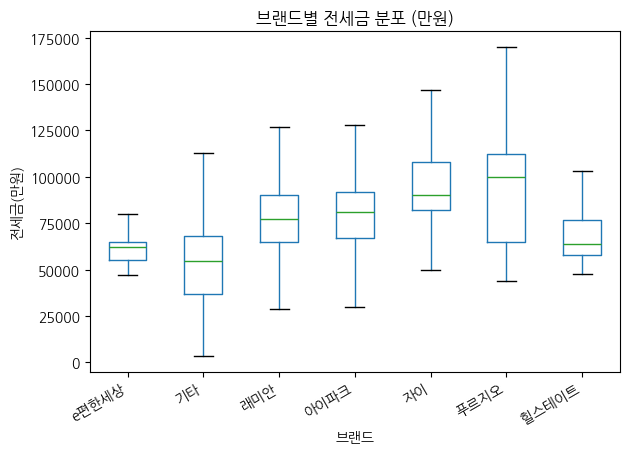

[저장] 브랜드별_전세금_분포_boxplot.png


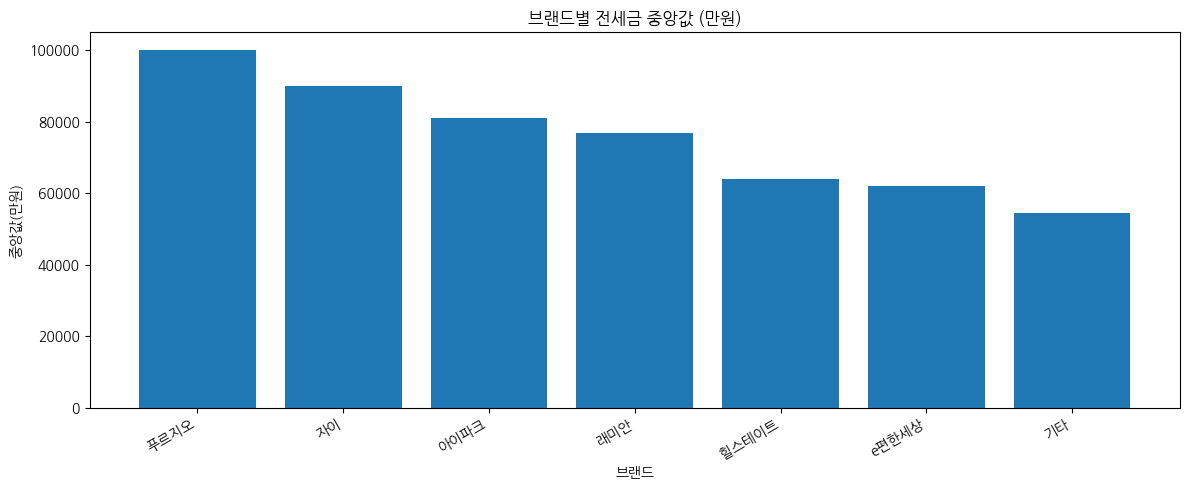

[저장] 브랜드별_전세금_중앙값_bar.png


<Figure size 1200x600 with 0 Axes>

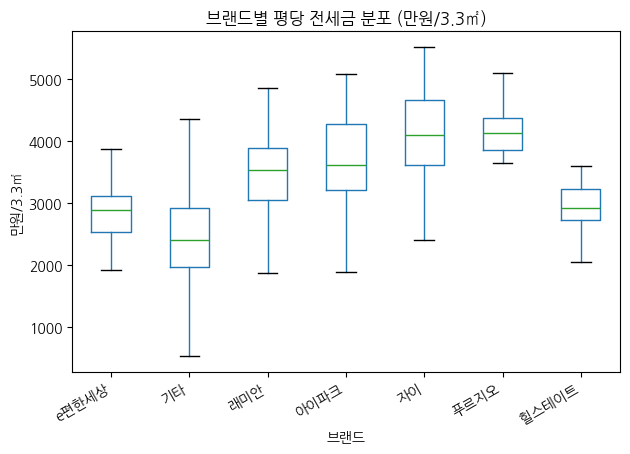

[저장] 브랜드별_평당전세금_분포_boxplot.png


In [ ]:
# -*- coding: utf-8 -*-
import os
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# =========================
# 0) 환경: 한글 폰트 설정
# =========================
mpl.rcParams['axes.unicode_minus'] = False
sysname = platform.system()
if sysname == "Windows":
    mpl.rcParams['font.family'] = "Malgun Gothic"
elif sysname == "Darwin":
    mpl.rcParams['font.family'] = "AppleGothic"
else:
    # Linux/Colab: 나눔고딕 설치 시도
    try:
        nanum = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
        if not os.path.exists(nanum):
            import subprocess
            subprocess.run(["apt-get", "-qq", "update"], check=True)
            subprocess.run(["apt-get", "-qq", "-y", "install", "fonts-nanum"], check=True)
        if os.path.exists(nanum):
            fm.fontManager.addfont(nanum)
            mpl.rcParams['font.family'] = "NanumGothic"
    except Exception:
        pass

# =========================
# 1) 데이터 로드 & 정리
# =========================
CSV_PATH = "아파트(전세)_서울마포구_갱신미사용만.csv"  # 파일 경로를 환경에 맞게 수정

# 인코딩 시도
try:
    df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(CSV_PATH, encoding="cp949")

# 필수 컬럼 점검
need_cols = ["단지명", "보증금(만원)"]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"필수 컬럼 누락: {missing}")

# 보증금 숫자화 (문자열에 쉼표가 있을 수 있음)
if df["보증금(만원)"].dtype == object:
    df["보증금(만원)"] = (
        df["보증금(만원)"].astype(str).str.replace(",", "", regex=False)
        .replace({"": np.nan, "-": np.nan})
        .astype(float)
    )

# =========================
# 2) 단지명 → 브랜드 추출
# =========================
# 자주 쓰이는 브랜드 키워드 패턴 (필요시 추가/수정)
brand_patterns = [
    (r"래미안", "래미안"),
    (r"자이", "자이"),
    (r"푸르지오", "푸르지오"),
    (r"롯데\s*캐슬|롯데캐슬", "롯데캐슬"),
    (r"힐스테이트", "힐스테이트"),
    (r"e\s*편한세상|e편한세상|e-편한세상", "e편한세상"),
    (r"아이파크|IPARK", "아이파크"),
    (r"더샵", "더샵"),
    (r"센트레빌", "센트레빌"),
    (r"위브", "위브"),
    (r"스위첸", "스위첸"),
    (r"호반\s*베르디움|베르디움", "호반베르디움"),
    (r"우남", "우남"),
    (r"두산위브", "두산위브"),
    (r"트리마제", "트리마제"),
    (r"리버뷰|리버스", "리버뷰"),
    (r"리센츠", "리센츠"),
    (r"수자인", "수자인"),
    (r"에코델타|에코", "에코"),
    # 필요 시 계속 추가
]

def extract_brand(name: str) -> str:
    if not isinstance(name, str):
        return "기타"
    for pat, label in brand_patterns:
        if re.search(pat, name, flags=re.IGNORECASE):
            return label
    return "기타"

df["브랜드"] = df["단지명"].apply(extract_brand)

# =========================
# 3) 분석용 필터 (옵션)
# =========================
# 표본이 너무 적은 브랜드는 제외 (예: 10건 미만 제거)
min_samples = 10
brand_counts = df.groupby("브랜드")["보증금(만원)"].count()
valid_brands = brand_counts[brand_counts >= min_samples].index.tolist()
df_plot = df[df["브랜드"].isin(valid_brands)].dropna(subset=["보증금(만원)"])

if df_plot.empty:
    raise ValueError("유효 브랜드 표본이 없습니다. min_samples를 낮추거나 brand_patterns를 점검하세요.")

# =========================
# 4) Boxplot: 브랜드별 전세금 분포
# =========================
plt.figure(figsize=(12, 6))
# 브랜드 정렬: 중앙값 높은 순
order = (
    df_plot.groupby("브랜드")["보증금(만원)"]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)
# 박스플롯
df_plot.boxplot(column="보증금(만원)", by="브랜드", grid=False, showfliers=False)
plt.suptitle("")  # 자동 제목 제거
plt.title("브랜드별 전세금 분포 (만원)")
plt.xlabel("브랜드")
plt.ylabel("전세금(만원)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
BOX_PNG = "브랜드별_전세금_분포_boxplot.png"
plt.savefig(BOX_PNG, dpi=150)
plt.show()
print(f"[저장] {BOX_PNG}")

# =========================
# 5) Bar: 브랜드별 전세금 중앙값 (옵션)
# =========================
median_by_brand = (
    df_plot.groupby("브랜드")["보증금(만원)"]
    .median()
    .sort_values(ascending=False)
)
plt.figure(figsize=(12, 5))
plt.bar(median_by_brand.index, median_by_brand.values)
plt.title("브랜드별 전세금 중앙값 (만원)")
plt.xlabel("브랜드")
plt.ylabel("중앙값(만원)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
BAR_PNG = "브랜드별_전세금_중앙값_bar.png"
plt.savefig(BAR_PNG, dpi=150)
plt.show()
print(f"[저장] {BAR_PNG}")

# =========================
# 6) (선택) 면적 보정 비교: 3.3㎡당 전세금
# =========================
if "전용면적(㎡)" in df_plot.columns:
    df_area = df_plot.copy()
    df_area = df_area[df_area["전용면적(㎡)"] > 0]
    # 3.3㎡(1평)당 전세금(만원)
    df_area["평당전세금(만원)"] = df_area["보증금(만원)"] / (df_area["전용면적(㎡)"] / 3.3)

    # 박스플롯 (평당)
    plt.figure(figsize=(12, 6))
    df_area.boxplot(column="평당전세금(만원)", by="브랜드", grid=False, showfliers=False)
    plt.suptitle("")
    plt.title("브랜드별 평당 전세금 분포 (만원/3.3㎡)")
    plt.xlabel("브랜드")
    plt.ylabel("만원/3.3㎡")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    PER_PNG = "브랜드별_평당전세금_분포_boxplot.png"
    plt.savefig(PER_PNG, dpi=150)
    plt.show()
    print(f"[저장] {PER_PNG}")



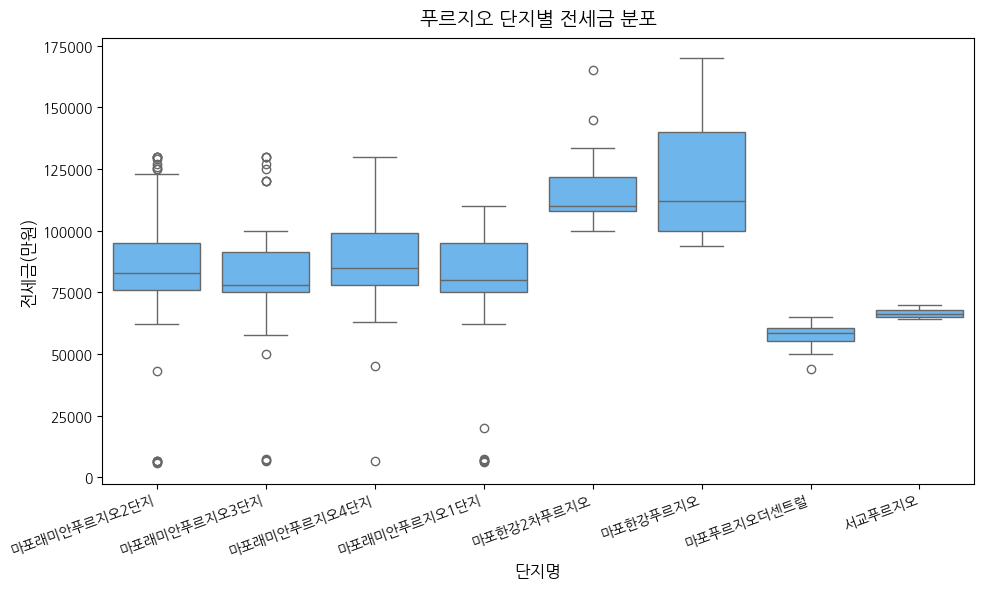

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import platform, os, matplotlib.font_manager as fm

# ====== 1️⃣ 한글 폰트 설정 ======
mpl.rcParams['axes.unicode_minus'] = False
sysname = platform.system()
if sysname == "Windows":
    mpl.rcParams['font.family'] = "Malgun Gothic"
elif sysname == "Darwin":
    mpl.rcParams['font.family'] = "AppleGothic"
else:
    try:
        nanum = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
        if not os.path.exists(nanum):
            import subprocess
            subprocess.run(["apt-get", "-qq", "update"], check=True)
            subprocess.run(["apt-get", "-qq", "-y", "install", "fonts-nanum"], check=True)
        if os.path.exists(nanum):
            fm.fontManager.addfont(nanum)
            mpl.rcParams['font.family'] = "NanumGothic"
    except Exception:
        pass

# ====== 2️⃣ 데이터 로드 ======
file_path = "아파트(전세)_서울마포구_갱신미사용만.csv"

try:
    df = pd.read_csv(file_path, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding="cp949")

# ====== 3️⃣ 데이터 전처리 ======
# 보증금 컬럼 정리
df["보증금(만원)"] = (
    df["보증금(만원)"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({"": None, "-": None})
    .astype(float)
)

# 푸르지오만 필터링
df_p = df[df["단지명"].str.contains("푸르지오", na=False)]

if df_p.empty:
    raise ValueError("데이터 내에 '푸르지오' 단지가 없습니다. 철자 확인 필요.")

# ====== 4️⃣ 박스플롯 시각화 ======
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_p,
    x="단지명",
    y="보증금(만원)",
    color="#58B8FF"
)
plt.title("푸르지오 단지별 전세금 분포", fontsize=14, pad=10)
plt.xlabel("단지명", fontsize=12)
plt.ylabel("전세금(만원)", fontsize=12)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


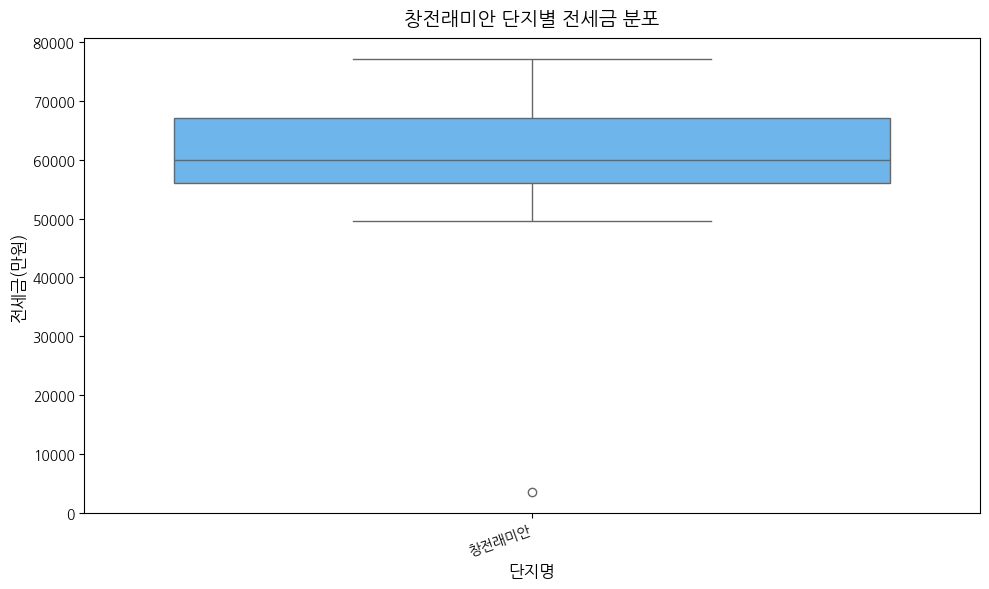

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import platform, os, matplotlib.font_manager as fm

# ====== 1️⃣ 한글 폰트 설정 ======
mpl.rcParams['axes.unicode_minus'] = False
sysname = platform.system()
if sysname == "Windows":
    mpl.rcParams['font.family'] = "Malgun Gothic"
elif sysname == "Darwin":
    mpl.rcParams['font.family'] = "AppleGothic"
else:
    try:
        nanum = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
        if not os.path.exists(nanum):
            import subprocess
            subprocess.run(["apt-get", "-qq", "update"], check=True)
            subprocess.run(["apt-get", "-qq", "-y", "install", "fonts-nanum"], check=True)
        if os.path.exists(nanum):
            fm.fontManager.addfont(nanum)
            mpl.rcParams['font.family'] = "NanumGothic"
    except Exception:
        pass

# ====== 2️⃣ 데이터 로드 ======
file_path = "아파트(전세)_서울마포구_갱신미사용만.csv"

try:
    df = pd.read_csv(file_path, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding="cp949")

# ====== 3️⃣ 데이터 전처리 ======
# 보증금 컬럼 정리
df["보증금(만원)"] = (
    df["보증금(만원)"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({"": None, "-": None})
    .astype(float)
)

# 푸르지오만 필터링
df_p = df[df["단지명"].str.contains("창전래미안", na=False)]

if df_p.empty:
    raise ValueError("데이터 내에 '창전래미안' 단지가 없습니다. 철자 확인 필요.")

# ====== 4️⃣ 박스플롯 시각화 ======
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_p,
    x="단지명",
    y="보증금(만원)",
    color="#58B8FF"
)
plt.title("창전래미안 단지별 전세금 분포", fontsize=14, pad=10)
plt.xlabel("단지명", fontsize=12)
plt.ylabel("전세금(만원)", fontsize=12)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


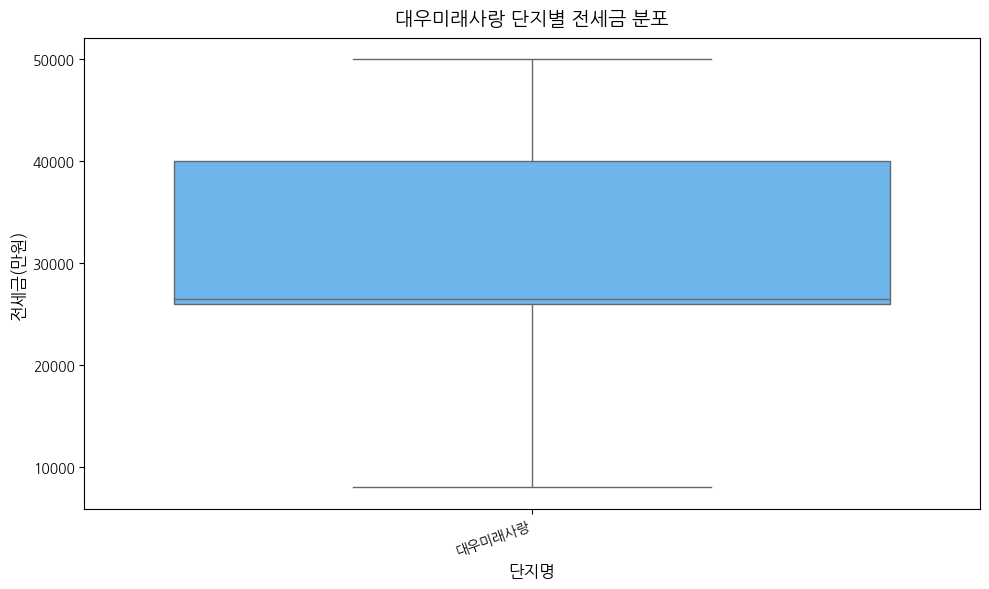

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import platform, os, matplotlib.font_manager as fm

# ====== 1️⃣ 한글 폰트 설정 ======
mpl.rcParams['axes.unicode_minus'] = False
sysname = platform.system()
if sysname == "Windows":
    mpl.rcParams['font.family'] = "Malgun Gothic"
elif sysname == "Darwin":
    mpl.rcParams['font.family'] = "AppleGothic"
else:
    try:
        nanum = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
        if not os.path.exists(nanum):
            import subprocess
            subprocess.run(["apt-get", "-qq", "update"], check=True)
            subprocess.run(["apt-get", "-qq", "-y", "install", "fonts-nanum"], check=True)
        if os.path.exists(nanum):
            fm.fontManager.addfont(nanum)
            mpl.rcParams['font.family'] = "NanumGothic"
    except Exception:
        pass

# ====== 2️⃣ 데이터 로드 ======
file_path = "아파트(전세)_서울마포구_갱신미사용만.csv"

try:
    df = pd.read_csv(file_path, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding="cp949")

# ====== 3️⃣ 데이터 전처리 ======
# 보증금 컬럼 정리
df["보증금(만원)"] = (
    df["보증금(만원)"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({"": None, "-": None})
    .astype(float)
)

# 푸르지오만 필터링
df_p = df[df["단지명"].str.contains("대우미래사랑", na=False)]

if df_p.empty:
    raise ValueError("데이터 내에 '대우미래사랑' 단지가 없습니다. 철자 확인 필요.")

# ====== 4️⃣ 박스플롯 시각화 ======
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_p,
    x="단지명",
    y="보증금(만원)",
    color="#58B8FF"
)
plt.title("대우미래사랑 단지별 전세금 분포", fontsize=14, pad=10)
plt.xlabel("단지명", fontsize=12)
plt.ylabel("전세금(만원)", fontsize=12)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

In [8]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm

# ======================================================
# 1️⃣ 파일 경로 설정
# ======================================================
APT_CSV = "아파트(전세)_서울마포구_갱신미사용만.csv"     # 아파트 목록
SUBWAY_CSV = "seoul_subway_stations.csv"              # 지하철역 목록
SCHOOL_CSV = "seoul_schools.csv"                      # 학교 목록
MART_CSV = "seoul_marts.csv"                          # 대형마트 목록
OUTPUT_CSV = "아파트_거리정보_통합추가.csv"              # 결과 저장 파일

# ======================================================
# 2️⃣ 데이터 로드
# ======================================================
def read_csv_auto(path):
    try:
        return pd.read_csv(path, encoding="utf-8-sig")
    except:
        return pd.read_csv(path, encoding="cp949")

df = read_csv_auto(APT_CSV)
subway = read_csv_auto(SUBWAY_CSV)
school = read_csv_auto(SCHOOL_CSV)
mart = read_csv_auto(MART_CSV)

# ======================================================
# 3️⃣ 아파트 좌표가 없는 경우 → 주소로 지오코딩 (느리지만 자동 처리)
# ======================================================
if "위도" not in df.columns or "경도" not in df.columns:
    print("⚠️ 위도/경도 없음 → Nominatim으로 주소 변환 시작")
    geolocator = Nominatim(user_agent="multi_distance_calc")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    lat, lon = [], []
    for addr in tqdm(df["시군구"] + " " + df["단지명"], desc="지오코딩"):
        try:
            loc = geocode("서울특별시 " + addr)
            if loc:
                lat.append(loc.latitude)
                lon.append(loc.longitude)
            else:
                lat.append(None); lon.append(None)
        except:
            lat.append(None); lon.append(None)
    df["위도"] = lat
    df["경도"] = lon

df = df.dropna(subset=["위도", "경도"]).copy()

# ======================================================
# 4️⃣ 거리 계산 함수 정의 (BallTree + haversine)
# ======================================================
def calc_nearest_facility(df, facility_df, fac_name_col, prefix):
    """
    df: 아파트 DataFrame
    facility_df: 시설 (학교/지하철/마트)
    fac_name_col: 시설명 컬럼 이름
    prefix: 새 컬럼 접두어 (예: '학교', '지하철', '마트')
    """
    # Check if required columns exist in facility_df
    if "위도" not in facility_df.columns or "경도" not in facility_df.columns:
        print(f"⚠️ '{prefix}' 데이터에 '위도' 또는 '경도' 컬럼이 없습니다. 거리 계산을 건너뜝니다.")
        df[f"{prefix}거리_m"] = np.nan
        df[f"최근접{prefix}명"] = None
        return df

    facility_df = facility_df.dropna(subset=["위도", "경도"]).copy()
    if facility_df.empty:
        print(f"⚠️ '{prefix}' 데이터에 유효한 좌표가 없습니다. 거리 계산을 건너뜝니다.")
        df[f"{prefix}거리_m"] = np.nan
        df[f"최근접{prefix}명"] = None
        return df

    facility_df["lat_rad"] = np.deg2rad(facility_df["위도"].astype(float))
    facility_df["lon_rad"] = np.deg2rad(facility_df["경도"].astype(float))

    tree = BallTree(np.c_[facility_df["lat_rad"], facility_df["lon_rad"]], metric="haversine")

    df["lat_rad"] = np.deg2rad(df["위도"].astype(float))
    df["lon_rad"] = np.deg2rad(df["경도"].astype(float))
    apts_rad = np.c_[df["lat_rad"], df["lon_rad"]]

    dist_rad, idx = tree.query(apts_rad, k=1)
    R = 6371000  # 지구 반경 (m)
    df[f"{prefix}거리_m"] = (dist_rad.flatten() * R).astype(int)
    df[f"최근접{prefix}명"] = facility_df.iloc[idx.flatten()][fac_name_col].values

    return df

# ======================================================
# 5️⃣ 세 가지 시설 거리 계산
# ======================================================
df = calc_nearest_facility(df, school, fac_name_col="학교명", prefix="학교")
df = calc_nearest_facility(df, subway, fac_name_col="역명", prefix="지하철")
df = calc_nearest_facility(df, mart, fac_name_col="상호명", prefix="마트") # Changed fac_name_col to "상호명" for mart data

# ======================================================
# 6️⃣ 불필요한 중간 컬럼 정리 & 저장
# ======================================================
df.drop(columns=["lat_rad", "lon_rad"], errors="ignore", inplace=True)
df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")

print(f"✅ '{OUTPUT_CSV}' 생성 완료!")
print(df[["단지명", "최근접학교명", "학교거리_m", "최근접지하철명", "지하철거리_m", "최근접마트명", "마트거리_m"]].head(10))

⚠️ 위도/경도 없음 → Nominatim으로 주소 변환 시작


지오코딩:   4%|▍         | 221/5139 [03:57<1:27:03,  1.06s/it]WARNING:urllib3.connectionpool:Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=%EC%84%9C%EC%9A%B8%ED%8A%B9%EB%B3%84%EC%8B%9C+%EC%84%9C%EC%9A%B8%ED%8A%B9%EB%B3%84%EC%8B%9C+%EB%A7%88%ED%8F%AC%EA%B5%AC+%EC%9A%A9%EA%B0%95%EB%8F%99+%EB%8C%80%EB%A6%BC2%EC%B0%A8&format=json&limit=1
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/http/client.py", line 1430, in getresponse
    respons

✅ '아파트_거리정보_통합추가.csv' 생성 완료!
            단지명  최근접학교명  학교거리_m   최근접지하철명  지하철거리_m     최근접마트명  마트거리_m
0    상암월드컵파크7단지    서울여고    5652  디지털미디어시티     1887  홈플러스 월드컵점    2069
1   상암월드컵파크10단지  창천초등학교    5870  디지털미디어시티     1996  홈플러스 월드컵점    2326
7            우성  공덕초등학교     663        마포      417   롯데마트 마포점     461
10       메세나폴리스    서울여고    1657        합정      148    이마트 신촌점    2146
14   상암월드컵파크1단지    서울여고    4386  디지털미디어시티      838  홈플러스 월드컵점     817
15   상암월드컵파크1단지    서울여고    4386  디지털미디어시티      838  홈플러스 월드컵점     817
16   상암월드컵파크7단지    서울여고    5652  디지털미디어시티     1887  홈플러스 월드컵점    2069
17  상암월드컵파크11단지  창천초등학교    6049  디지털미디어시티     2159  홈플러스 월드컵점    2541
36   상암월드컵파크1단지    서울여고    4386  디지털미디어시티      838  홈플러스 월드컵점     817
37   상암월드컵파크1단지    서울여고    4386  디지털미디어시티      838  홈플러스 월드컵점     817


In [10]:
df_3m = "/content/아파트_거리정보_통합추가.csv"
df_3m = pd.read_csv(df_3m, encoding="utf-8-sig")
df_3m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   시군구      1214 non-null   object 
 1   단지명      1214 non-null   object 
 2   전용면적(㎡)  1214 non-null   float64
 3   계약년월     1214 non-null   int64  
 4   계약일      1214 non-null   int64  
 5   보증금(만원)  1214 non-null   int64  
 6   층        1214 non-null   int64  
 7   건축년도     1214 non-null   int64  
 8   계약구분     1214 non-null   object 
 9   위도       1214 non-null   float64
 10  경도       1214 non-null   float64
 11  학교거리_m   1214 non-null   int64  
 12  최근접학교명   1214 non-null   object 
 13  지하철거리_m  1214 non-null   int64  
 14  최근접지하철명  1214 non-null   object 
 15  마트거리_m   1214 non-null   int64  
 16  최근접마트명   1214 non-null   object 
dtypes: float64(3), int64(8), object(6)
memory usage: 161.4+ KB
